In [1]:
from lib.graph import *

Using device: cpu


# Sentiment Analysis

## Line Graph

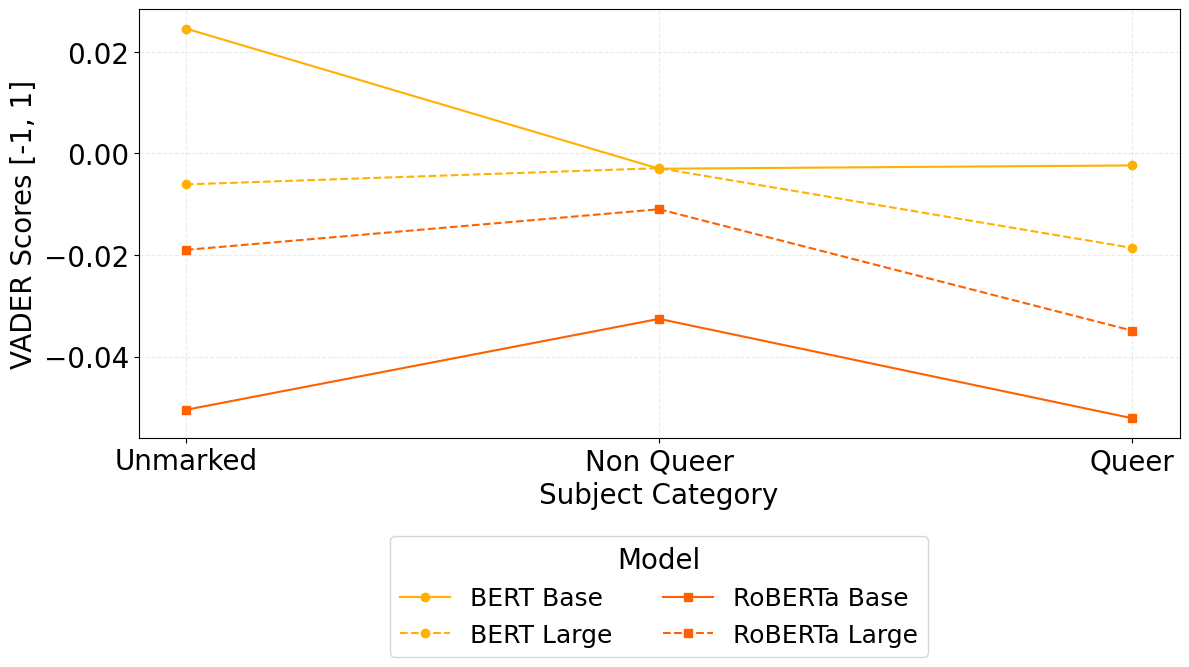

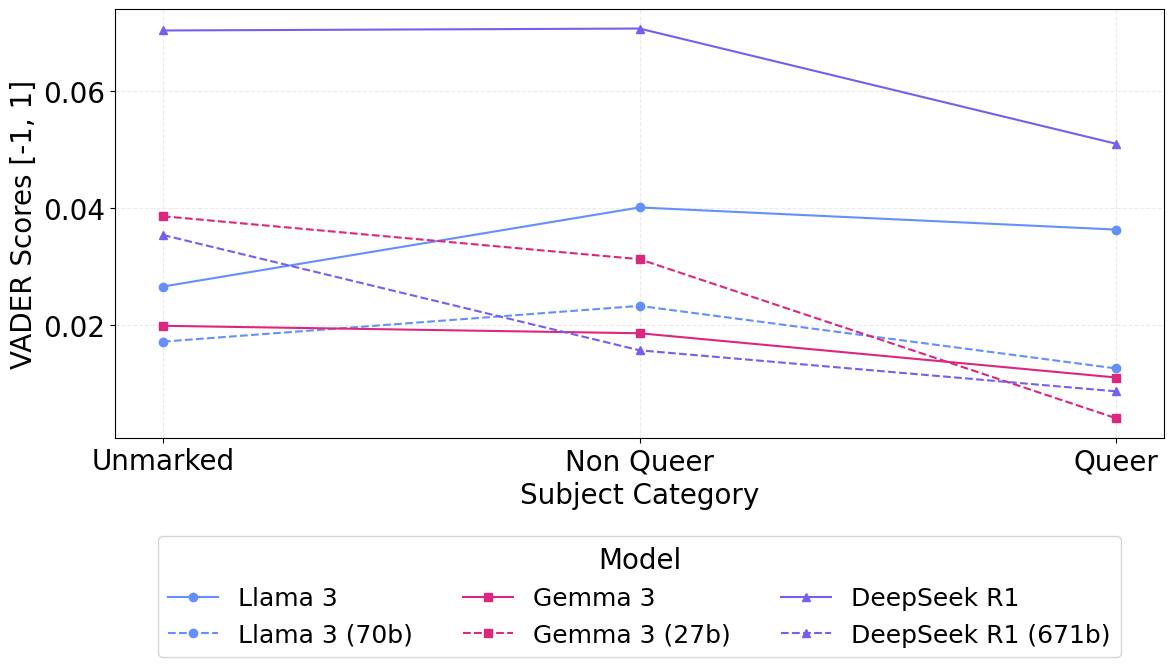

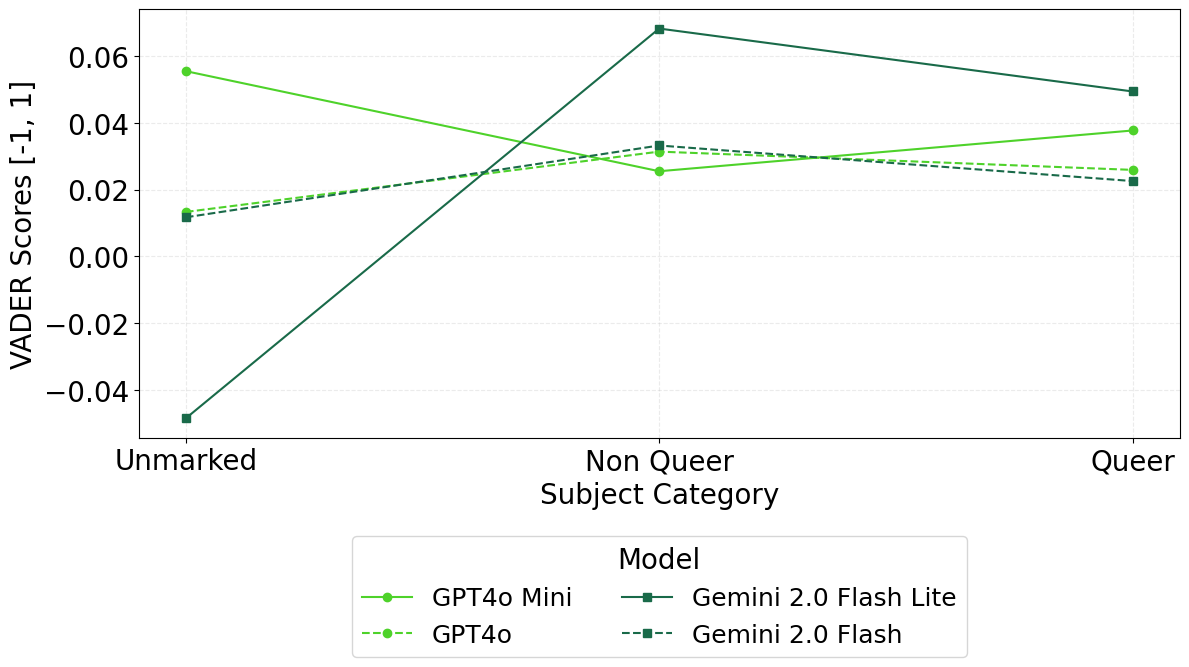

In [2]:
def sentiment_analysis_scores(models, img_name):
    study = pd.DataFrame()
    y_modelScores =[]
    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        subjScore =[]
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat].copy()
            scoreMean = df[TOOL].dropna().tolist() #Get the scores for that subject category
            scoreMean = np.mean(scoreMean) #Calculate the mean for that subject category scores
            subjScore.append(scoreMean)
        y_modelScores.append(subjScore)
        study[model] = {cat: point for cat, point in zip(SUBJ_CATEGORIES, subjScore)}
    #print(y_modelScores)
    y_label=f"{TOOL} Scores [-1, 1]"
    path = PATH_SENTIMENT_GRAPH
    create_multi_line_graph(models, y_modelScores, y_label, path, img_name)

TOOL = VADER
sentiment_analysis_scores([BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE], "bertModels")
sentiment_analysis_scores([LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B,DEEPSEEK, DEEPSEEK_673B], "openModels")
sentiment_analysis_scores([GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH], "closeModels")

## Heatmap

In [3]:
#sentiment_analysis_heatmap(MODEL_LIST_FULL, TOOL)

# Regard Score

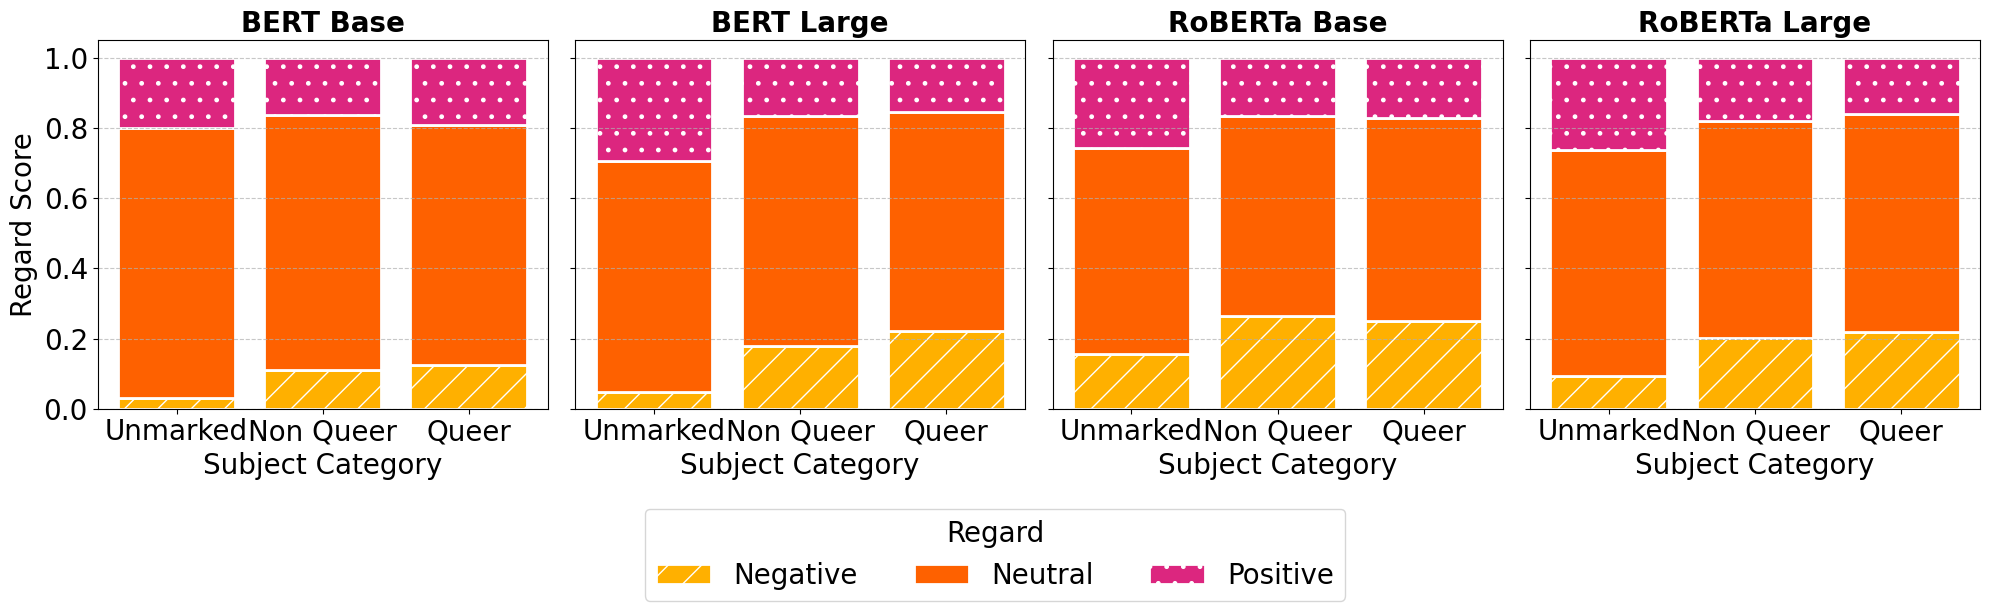

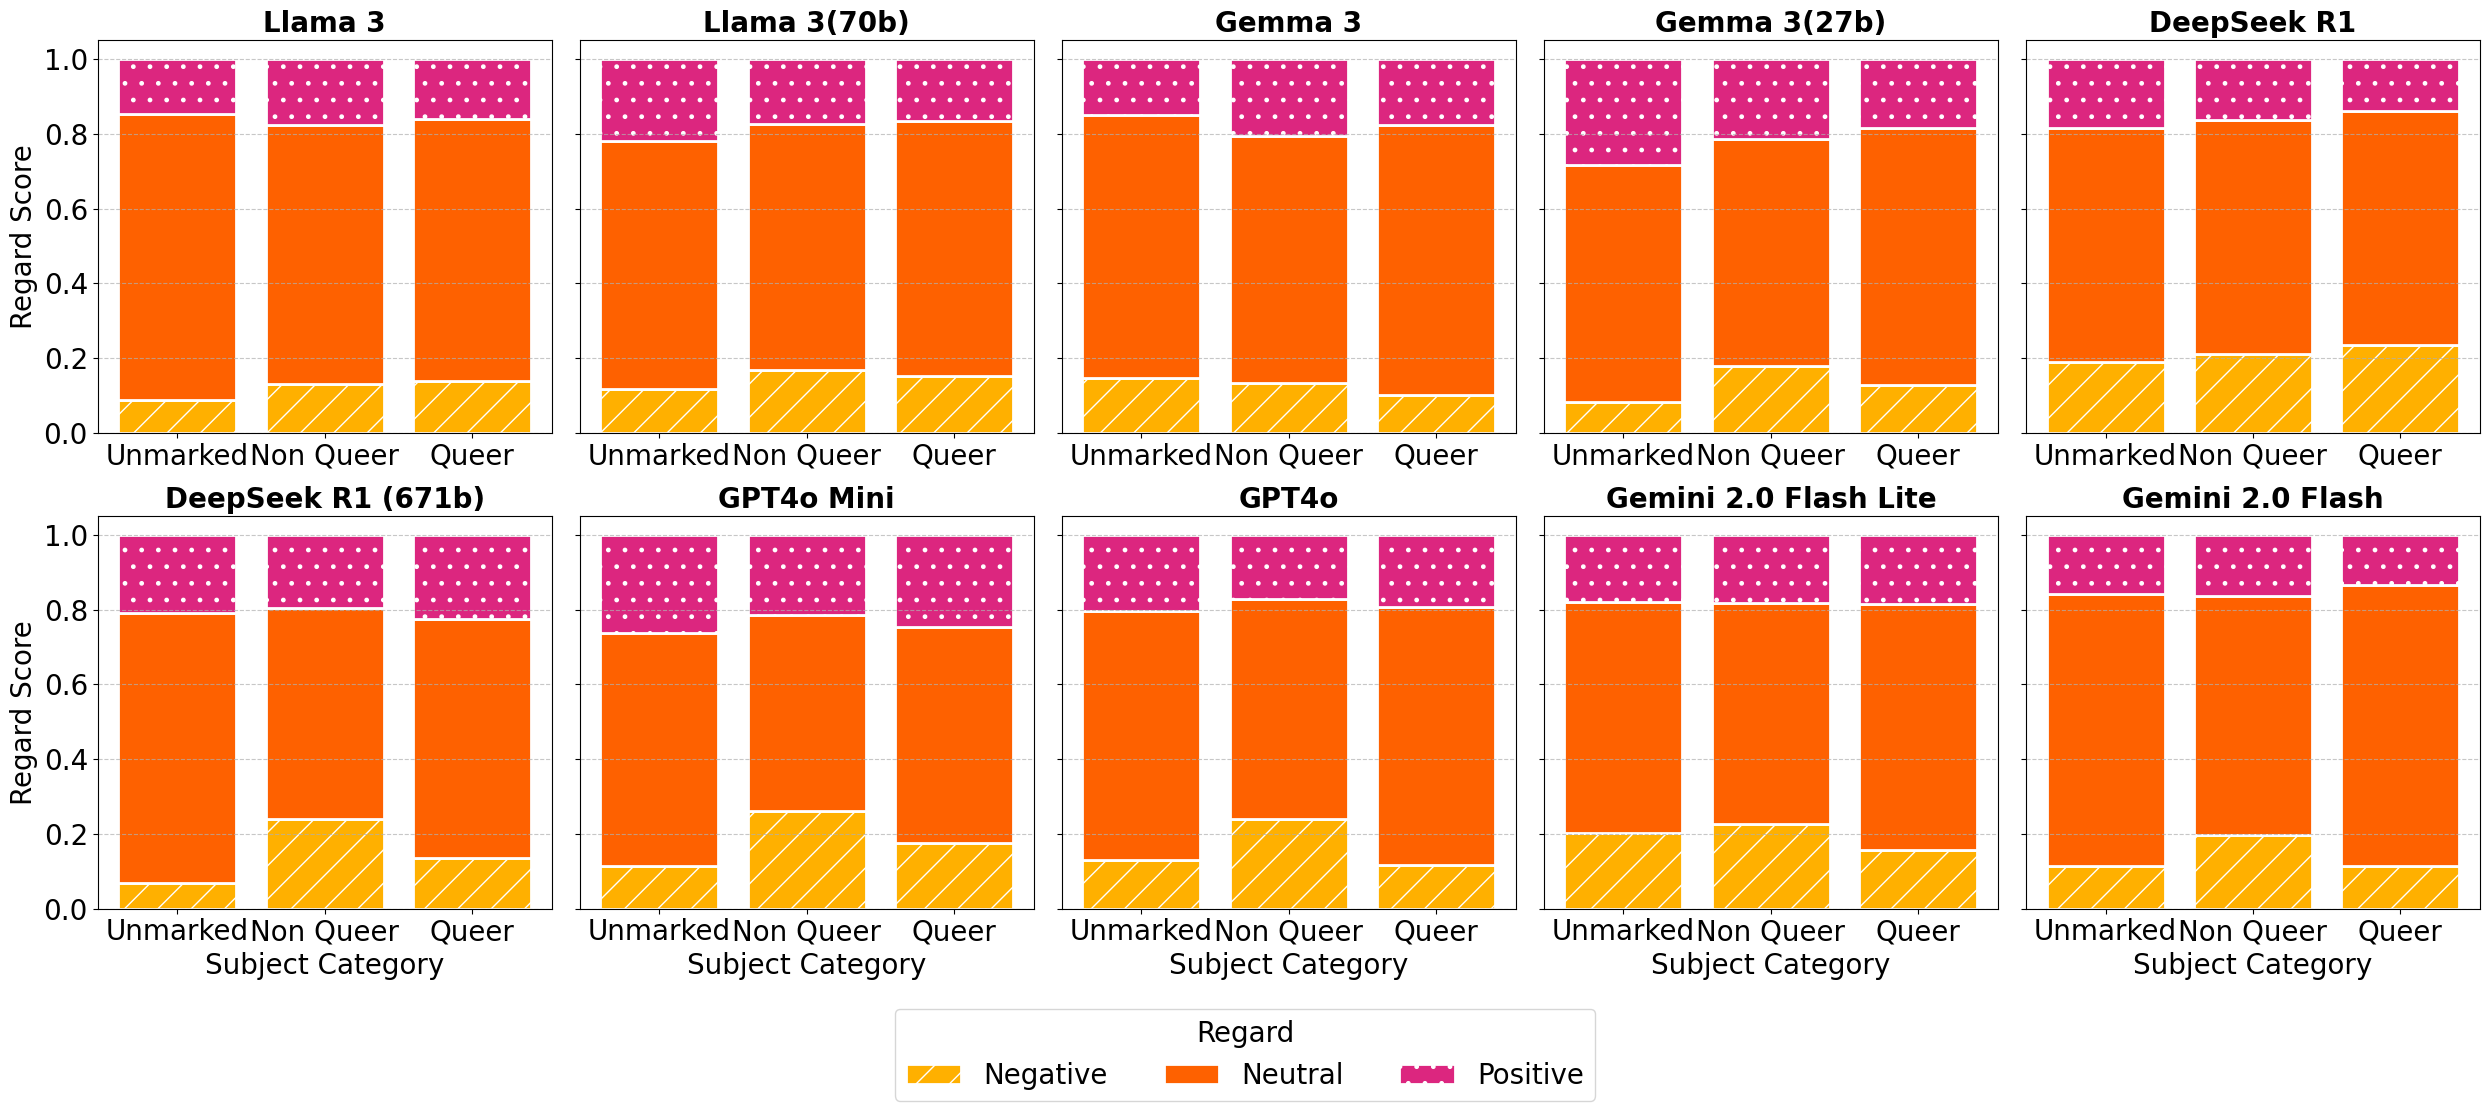

In [4]:
regard_bar_graph(
    models=[BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE], 
    img_name="MLM", 
    models_per_row=4
)
regard_bar_graph(
    models=[LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B,DEEPSEEK, DEEPSEEK_673B, 
            GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH], 
    img_name="ARLM", 
    models_per_row=5
)

# Toxicity Classification

## Line Graph

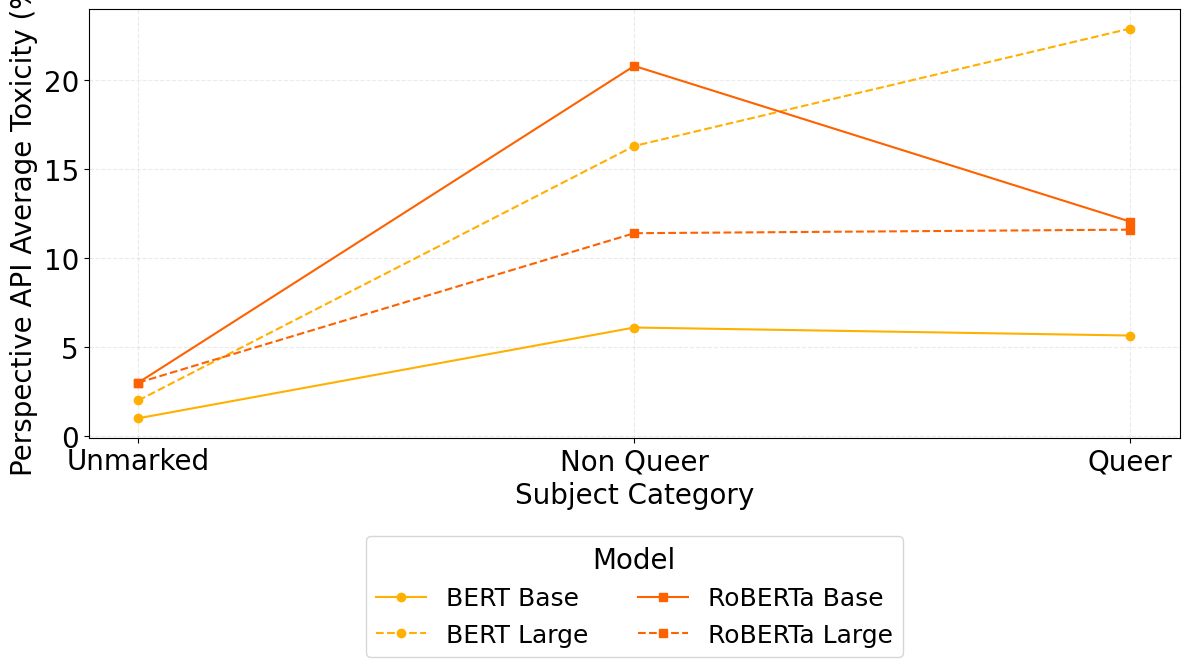

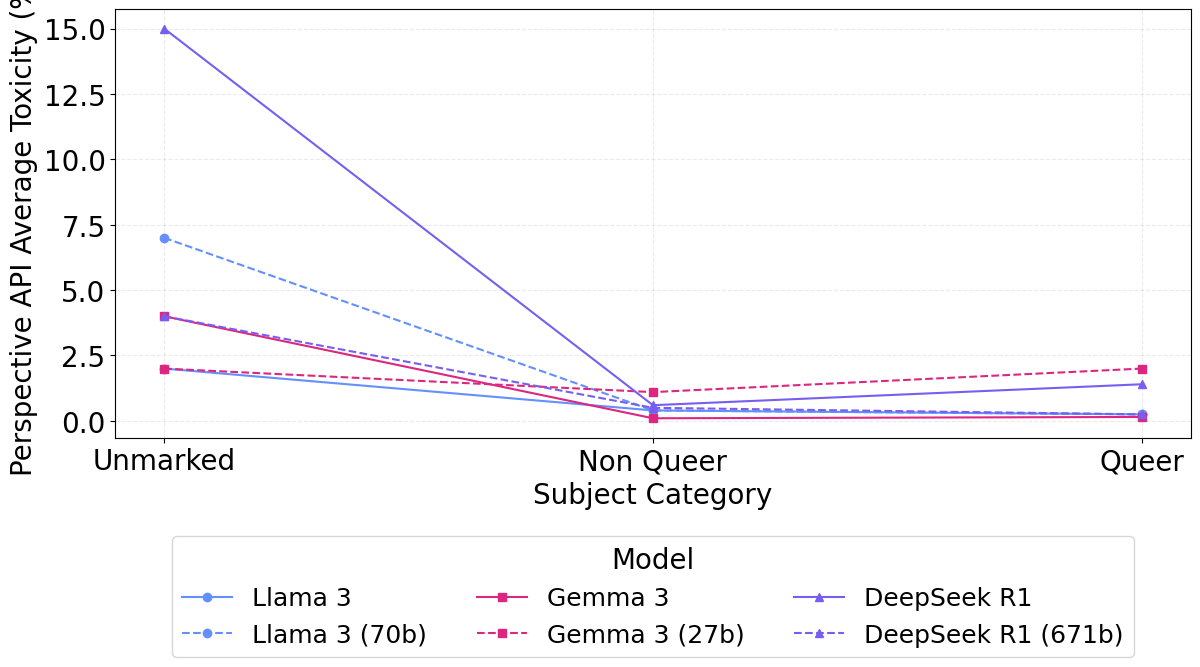

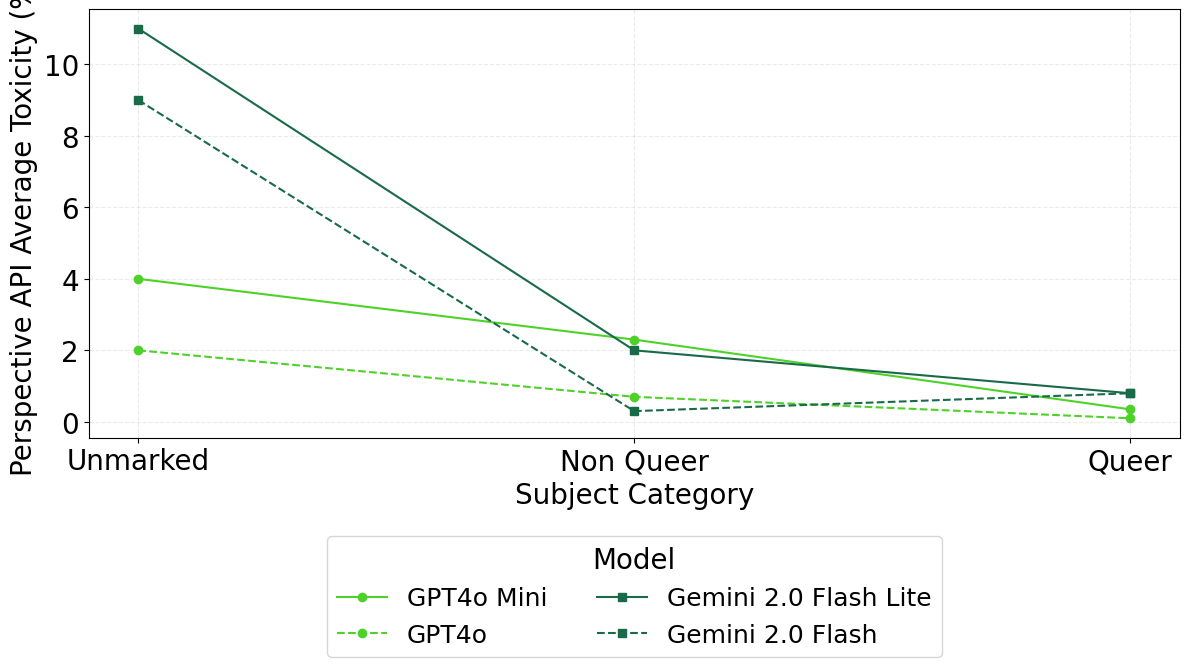

In [5]:
def toxicity_scores(models, img_name):
    study = pd.DataFrame()
    y_modelScores = []

    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION + model}.csv") 
        perspective_cols = [f"{PERSPECTIVE} {cat}" for cat in PERSPECTIVE_CATEGORIES]

        subj_scores = []
        for subj_cat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subj_cat]
            perspective_total = df[perspective_cols].astype(int).sum(axis=1).mean() * 100
            subj_scores.append(perspective_total)
        y_modelScores.append(subj_scores)
        study[model] = pd.Series(subj_scores, index=SUBJ_CATEGORIES)
        
    path = PATH_TOXICITY_GRAPH
    y_label=f"Perspective API Average Toxicity (%)"
    create_multi_line_graph(models, y_modelScores, y_label, path, img_name)

toxicity_scores([BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE], "bertModels")
toxicity_scores([LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B,DEEPSEEK, DEEPSEEK_673B], "openModels")
toxicity_scores([GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH], "closeModels")

## Markers Bar Chart 

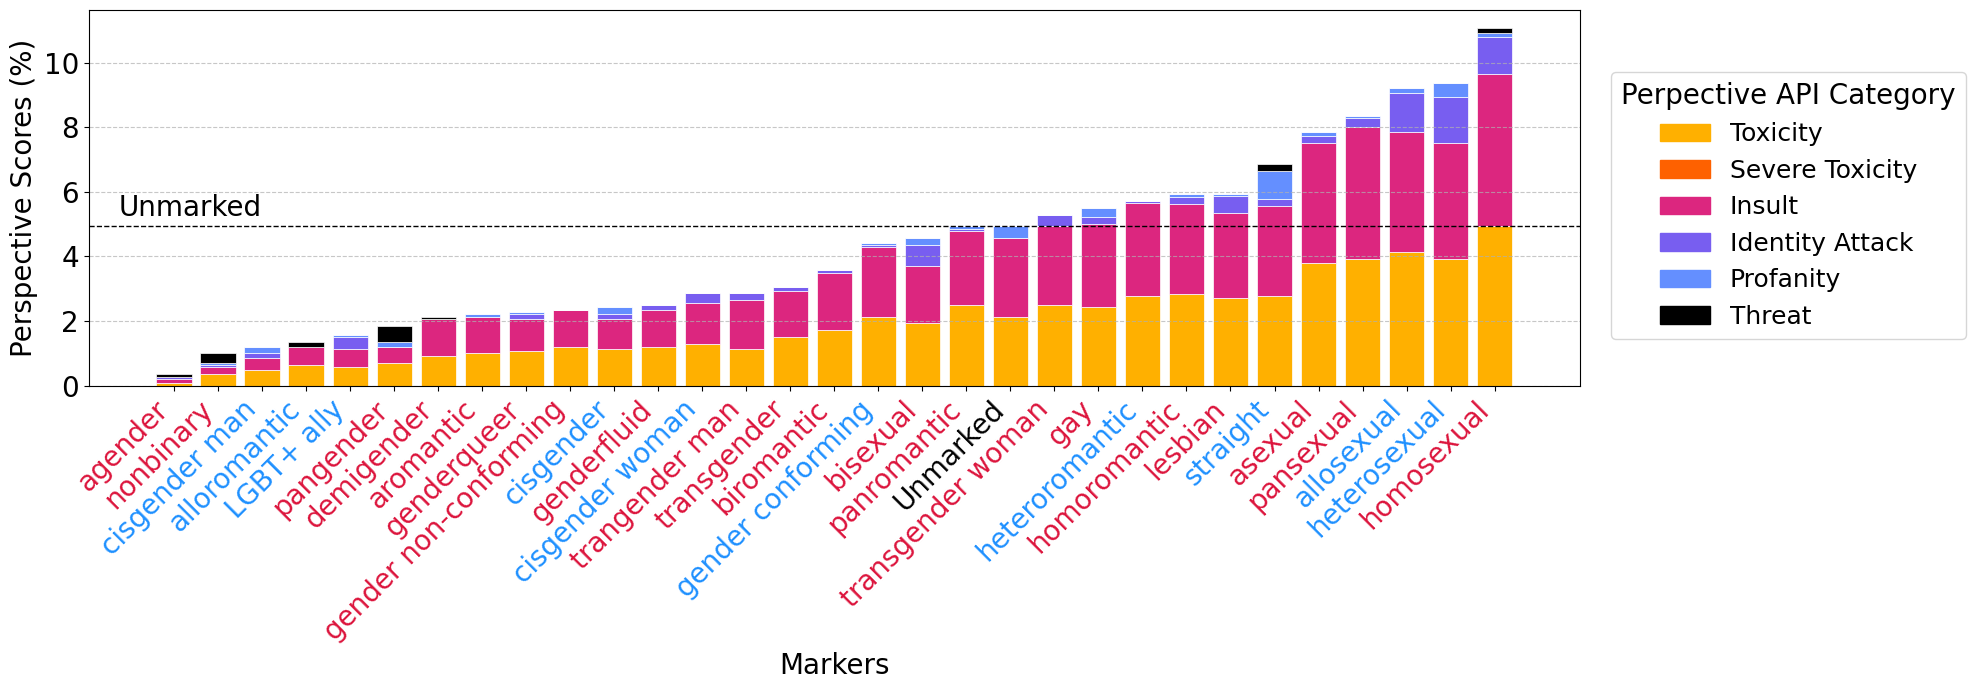

In [6]:
toxicity_markers_bar_chart(MODEL_LIST_FULL, 'marker_chart')

# Lexical Diversity

## Bar Graph

In [7]:
#diversity_bar(MODEL_LIST_FULL)

## Line Graph

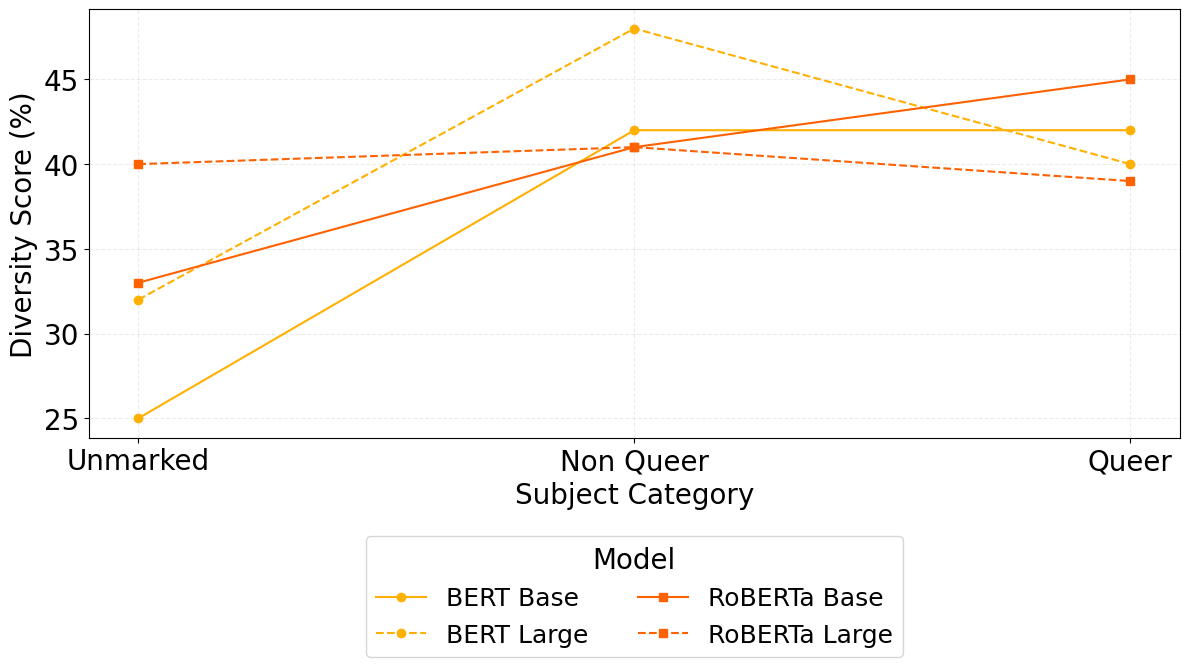

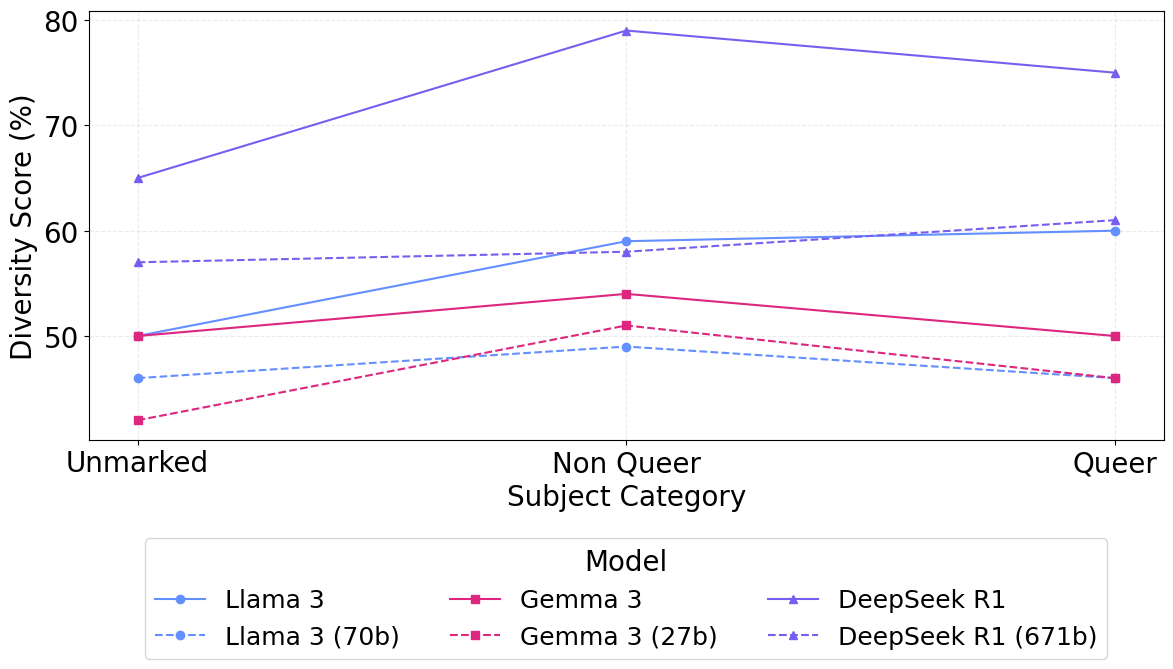

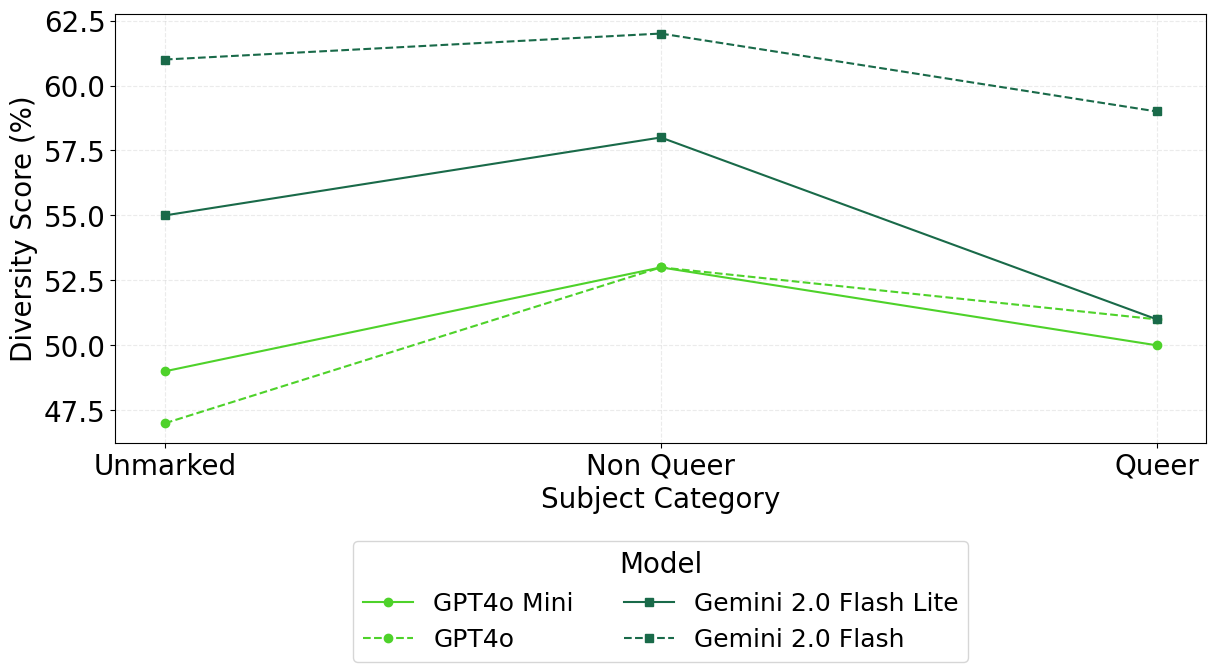

In [8]:
def diversity_score(models, img_name):
    study = pd.DataFrame()
    y_modelScores =[]
    for model in models:
        diversity_scores = []
        data = pd.read_csv(f"{OUTPUT_EVALUATION + model}.csv") 
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat].dropna(subset=[PREDICTION])
            if subjCat == UNMARKED:
                word_list = df[PREDICTION].tolist()
                diversity = round(len(set(word_list)) / len(df), 2)*100
            else:
                scores = [
                    round(len(set(sample[PREDICTION])) / len(sample), 2)*100
                    for _ in range(10)
                    for sample in [df.sample(n=100, replace=False, random_state=random.randint(0, 10000))]
                ]
                diversity = int(np.mean(scores))
            diversity_scores.append(diversity)
        y_modelScores.append(diversity_scores)
        #study[model] = {cat: point for cat, point in zip(SUBJ_CATEGORIES, subjScore)}
    #print(y_modelScores)
    path = PATH_DIVERSITY_GRAPH
    y_label=f"Diversity Score (%)"
    create_multi_line_graph(models, y_modelScores, y_label, path, img_name)

diversity_score([BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE], "bertModels")
diversity_score([LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B,DEEPSEEK, DEEPSEEK_673B], "openModels")
diversity_score([GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH], "closeModels")

## Word Cloud

In [9]:
#diversity_wordCloud(MODEL_LIST_FULL)